# (VAD) Velocity Azimuth Display

Argonne National Laboratory

Original code by Scott Collis:

https://github.com/scollis/notebooks/blob/master/DYNAMO%20AIME%20workshop%20workbook.ipynb

In [3]:
import re
import os
import pyart
import matplotlib.pyplot as plt
import scipy
from boto.s3.connection import S3Connection
import gzip
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
import numpy.ma as ma
warnings.filterwarnings("ignore")
%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119 


In [29]:
"""
pyart.retrieve.velocity_azimuth_display
=======================================

Retrieval of VADs from a radar object.

Code adapted by Scott Collis,

"Below is some code from Susan Rennie (based off Michelson et al 2000)
from the Centre for Australian Weather and Climate Research (CAWCR)
for calculating VADs. I used her one tilt version and wrote my own
adaptation into Py-ART PyRadar object.. Note I convert to U and V before
averaging.. my concern is that if you have θ rapidly varying between
360° and 0° this will average to a nonsense number" (Collis).

.. autosummary::
    :toctreeL generated/
    :template: dev_template.rst

    Velocity Azimuth Display

"""


import numpy as np
import scipy
import pyart

def velocity_azimuth_display(radar, corrected_velocity=None,
                             z_start=500, z_end=10500, z_count=101,
                             norm_coh_power=None,
                             norm_coh_power_value=0.5,
                             nyquist_velocity=None):
    """
    Velocity azimuth display.

    Parameters
    ----------
    radar : Radar
        Radar object used.
    corrected_velocity : string
        Velocity field to use for VAD calculation.
        If None, the field 'velocity' will be corrected using
        Py-ART's region based radar dealiasing algorithm,
        and field then used is the new 'corrected_velocity'.

    Other Parameters
    ----------------
    z_start : int
        Z location to begin VAD calculation in meters,
        default=0.
    z_end : int
        Z location to end VAD calculation in meters,
        default=10500.
    z_count : int
        Amount of data points used between z_start and z_end.
        Data points are evenly spread out using np.linspace,
        default=101.
    norm_coh_power : string
        Normalized coherent power field to use for VAD calculation.
        If None, a default normal_coherent_power field will be
        created for the user with a default array of 0.5's.
    norm_coh_power_value : float
        The value to use to create field 'norm_coh_power'
        if not present. Also used as mask to exclude_below,
        default=0.5.
    nyquist_velocity : float
        The value to use for nyquist velocity in the radar
        dealiasing calculation. If None, default value is pulled
        from the radar object instrument parameters.
    Returns
    -------
    u_mean : array
        U-wind mean in meters per second.
    v_mean : array
        V-wind mean in meters per second.
    z_interval : array
        All z values from use of z_start, z_end,
        and z_count. This array is used for the
        VAD plot y-axis.

    References
    ----------
    Michelson, D. B., Andersson, T., Koistinen, J., Collier, C. G., Riedl, J.,
    Szturc, J., Gjertsen, U., Nielsen, A. and Overgaard, S. (2000) BALTEX Radar
    Data Centre Products and their Methodologies. In SMHI Reports. Meteorology
    and Climatology.Swedish Meteorological and Hydrological Institute, Norrkoping.

    """

    def interval_mean(data, current_z, wanted_z):
        """ Find the mean of data indexed by current_z
            at wanted_z on intervals wanted_z+/- delta
            wanted_z """
        delta = wanted_z[1] - wanted_z[0]
        pos_lower = [np.argsort((current_z - (wanted_z[i] - delta / 2.0))**2)[0]
                     for i in range(len(wanted_z))]
        pos_upper = [np.argsort((current_z - (wanted_z[i] + delta / 2.0))**2)[0]
                     for i in range(len(wanted_z))]
        new_values = np.array([data[pos_lower[i]:pos_upper[i]].mean()
                              for i in range(len(pos_upper))])
        return new_values

    def sd_to_uv(speed, direction):
        return (speed * np.sin(direction), speed * np.cos(direction))

    def VAD_algorithm(V, Az, El, Ra):
        ''' Calculates VAD for a scan, returns speed and angle
        outdic=VADf(V,Az,El,Ra)
        V is 2D array, Az, Ra are 1D arrays, El is number.
        All in degrees, m outdic contains speed, angle, variance. 
        '''
        nrays, nbins = V.shape
        nr2 = nrays / 2
        Vc = np.empty((nr2, nbins, 2))
        Vc[:, :, 0] = V[0:nr2, :]
        Vc[:, :, 1] = V[nr2:, :]
        sinaz = np.sin(np.radians(Az))
        cosaz = np.cos(np.radians(Az))
        sumv = np.ma.sum(Vc, 2)
        vals = np.isnan(sumv)
        vals2 = np.vstack((vals, vals))
        count = np.sum(np.isnan(sumv) == False, 0)
        aa = count < 8
        vals[:, aa] = 0
        vals2[:, aa] = 0
        count = np.float_(count)
        count[aa] = np.nan
        U_m = np.array([np.nansum(sumv, 0) / (2 * count)])
        count[aa] = 0

        CminusU_mcos = np.zeros((nrays, nbins))
        CminusU_msin = np.zeros((nrays, nbins))
        sincos = np.zeros((nrays, nbins))
        sin2 = np.zeros((nrays, nbins))
        cos2 = np.zeros((nrays, nbins))

        for i in range(nbins):
            CminusU_mcos[:, i] = cosaz * (V[:, i] - U_m[:, i])
            CminusU_msin[:, i] = sinaz * (V[:, i] - U_m[:, i])
            sincos[:, i] = sinaz * cosaz
            sin2[:, i] = sinaz**2
            cos2[:, i] = cosaz**2
        CminusU_mcos[vals2] = np.nan
        CminusU_msin[vals2] = np.nan
        sincos[vals2] = np.nan
        sin2[vals2] = np.nan
        cos2[vals2] = np.nan
        sumCminU_mcos = np.nansum(CminusU_mcos, 0)
        sumCminU_msin = np.nansum(CminusU_msin, 0)
        sumsincos = np.nansum(sincos, 0)
        sumsin2 = np.nansum(sin2, 0)
        sumcos2 = np.nansum(cos2, 0)
        a_value = (sumCminU_mcos - (sumsincos*sumCminU_msin / sumsin2))\
        / (sumcos2 - (sumsincos**2) / sumsin2)
        b_value = (sumCminU_msin - a_value*sumsincos) / sumsin2
        speed = np.sqrt(a_value**2 + b_value**2) / np.cos(np.radians(El))
        angle = np.arctan2(a_value, b_value)

        crv = np.empty((nrays, nbins))
        for i in range(nbins):
            crv[:, i] = np.sin(np.radians(Az) + angle[i])*speed[i]
        Vn = V.copy()
        Vn[vals2 == True] = np.nan
        var = np.nansum((crv - Vn)**2, 0) / (sum(np.isnan(Vn) == False) - 2)
        return {'speed' : speed, 'angle' : angle, 'variance' : var}

    def VAD_calculation(radar):
        speed = []
        angle = []
        height = []
        z = radar.gate_z['data']
        z_want = np.linspace(z_start, z_end, z_count)

        if norm_coh_power == None:
            # Copying a field and its shape to use as a
            # norm_coherent_power array with matching shape.
            radar.add_field_like('reflectivity', 'norm_coh_power',
                                 radar.fields['reflectivity']['data'].copy(),
                                 replace_existing=True)
            # Setting all values to norm_coh_power_value,
            # in the field norm_coh_power.
            (radar.fields['norm_coh_power']['data'])[
                radar.fields['norm_coh_power']['data'] !=
                norm_coh_power_value] = norm_coh_power_value
            norm_coh_power_used = 'norm_coh_power'
        else:
            norm_coh_power_used = norm_coh_power
        gatefilter = pyart.correct.GateFilter(radar)
        gatefilter.exclude_below(norm_coh_power_used, norm_coh_power_value)
        if 0 > norm_coh_power_value or norm_coh_power_value > 1:
            raise ValueError('Normalized coherent power is out of'
                             ' recommended range between 0 and 1.')

        if corrected_velocity == None:
            if nyquist_velocity == None:
                nyq = radar.instrument_parameters['nyquist_velocity']['data'][0]
            else:
                nyq = nyquist_velocity
            corr_vel = pyart.correct.dealias_region_based(
                radar, vel_field='velocity', keep_original=False, 
                gatefilter=gatefilter, nyquist_vel=None,
                centered=False)
            radar.add_field('corrected_velocity', corr_vel,
                              replace_existing=True)
            velocity_used = 'corrected_velocity'
        else:
            velocity_used = corrected_velocity

        if radar.fields[velocity_used]['units'] is not 'meters_per_second'\
        and radar.fields[velocity_used]['units'] is not 'm/s':
            raise ValueError('Field used for VAD Calculation needs to be'
                             ' a velocity field.')

        for i in range(len(radar.sweep_start_ray_index['data'])):
            i_s = radar.sweep_start_ray_index['data'][i]
            i_e = radar.sweep_end_ray_index['data'][i]
            if (i_e - i_s) % 2 == 0:
                print("even, all good")
            else:
                i_e = i_e - 1
            VR = radar.fields[velocity_used]['data'][i_s:i_e, :]
            # SQ = radar.fields[norm_coh_power_used]['data'][i_s:i_e, :]
            Az = radar.azimuth['data'][i_s:i_e]
            Ra = radar.range['data']
            El = radar.fixed_angle['data'][i]
            mask = VR.mask
            # crud = SQ < 0.5
            VR[np.where(mask)] = np.nan
            # VR[np.where(crud)] = np.nan
            one_level = VAD_algorithm(VR, Az, El, Ra / 1000.0)
            not_garbage = np.isfinite(one_level['speed'])
            print('max height', z[i_s, :][np.where(not_garbage)].max(),
                  ' meters')
            speed.append(one_level['speed'][np.where(not_garbage)])
            angle.append(one_level['angle'][np.where(not_garbage)])
            height.append(z[i_s, :][np.where(not_garbage)])

        speed_array = np.concatenate(speed)
        angle_array = np.concatenate(angle)
        height_array = np.concatenate(height)
        arg_order = height_array.argsort()
        speed_ordered = speed_array[arg_order]
        height_ordered = height_array[arg_order]
        angle_ordered = angle_array[arg_order]
        u_ordered, v_ordered = sd_to_uv(speed_ordered, angle_ordered)
        u_mean = interval_mean(u_ordered, height_ordered, z_want)
        v_mean = interval_mean(v_ordered, height_ordered, z_want)
        return z_want, u_mean, v_mean
    z_want, u_mean, v_mean = VAD_calculation(radar)
    return {'u_mean' : u_mean, 'v_mean' : v_mean, 'z_interval': z_want}

In [3]:
        #return z_want, speed_ordered, height_ordered, angle_ordered, u_mean, v_mean
    #z_want, speed_ordered, height_ordered, angle_ordered, u_mean, v_mean = VAD_calculation(radar)
    #return {'u_mean' : u_mean, 'v_mean' : v_mean,
            #'z_interval': z_want, 'speed': speed_ordered, 'height': height_ordered,
            #'angle': angle_ordered}

In [5]:
import numpy as np
filename = '/home/zsherman/training_exercises/data/KLOT20130417_235520_V06.gz'
myradar = pyart.io.read(filename)

In [19]:
filename2 = '/home/zsherman/training_exercises/data/KLOT20130417_235520_V06.gz'
myradar2 = pyart.io.read(filename2)

In [20]:
gatefilter = pyart.correct.GateFilter(myradar2)
corr_vel = pyart.correct.dealias_region_based(
    myradar2, vel_field='velocity', keep_original=False, 
    gatefilter=None, nyquist_vel=None, centered=True)
myradar2.add_field('corrected_velocity', corr_vel, replace_existing = True)

In [36]:
vad = velocity_azimuth_display(myradar, corrected_velocity=None, z_count=101)

max height 16378.3196353  meters
max height 16664.336786  meters
max height 18644.1409849  meters
max height 19831.749484  meters
max height 22733.8708519  meters
max height 23349.2962065  meters
max height 28314.2167915  meters
max height 31848.3092148  meters
max height 36936.2556392  meters
max height 44031.5646064  meters
max height 52728.7671706  meters
max height 62490.3668599  meters
max height 76743.0034827  meters
max height 91638.9944802  meters
max height 112526.51153  meters
max height 134714.181605  meters
max height 163740.607128  meters


In [77]:
test_radar = pyart.io.read(pyart.testing.NEXRAD_ARCHIVE_MSG1_FILE)

In [78]:
vad2 = velocity_azimuth_display(test_radar, corrected_velocity=None,
                                z_start=0, z_end=4000,
                                z_count=20, nyquist_velocity=28.5)

even, all good
max height 16281.1018341  meters
even, all good
max height 16281.1018341  meters
max height 24364.1850108  meters
even, all good
max height 24364.1850108  meters
max height 32085.2190865  meters
max height 40493.7490405  meters
max height 47836.7346566  meters


In [34]:
vad3 = velocity_azimuth_display(myradar,
                                corrected_velocity='velocity',
                                z_count=202)

max height 16378.3196353  meters
max height 16664.336786  meters
max height 18644.1409849  meters
max height 19831.749484  meters
max height 22733.8708519  meters
max height 23349.2962065  meters
max height 28314.2167915  meters
max height 31848.3092148  meters
max height 36936.2556392  meters
max height 44031.5646064  meters
max height 52728.7671706  meters
max height 62490.3668599  meters
max height 76743.0034827  meters
max height 91638.9944802  meters
max height 112526.51153  meters
max height 134714.181605  meters
max height 163740.607128  meters


In [12]:
myradar.fields['corrected_velocity']['data']

masked_array(data =
 [[-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 ..., 
 [-1.5 1.5 -1.0 ..., -- -- --]
 [-1.0 0.5 0.5 ..., -- -- --]
 [-1.5 0.5 -0.5 ..., -- -- --]],
             mask =
 [[ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 ..., 
 [False False False ...,  True  True  True]
 [False False False ...,  True  True  True]
 [False False False ...,  True  True  True]],
       fill_value = -9999.0)

In [21]:
#test_radar = pyart.testing.make_velocity_aliased_radar(alias=False)

In [66]:
#(test_radar.fields['velocity']['data'])[
    #test_radar.fields['velocity']['data'] != 25] = 25

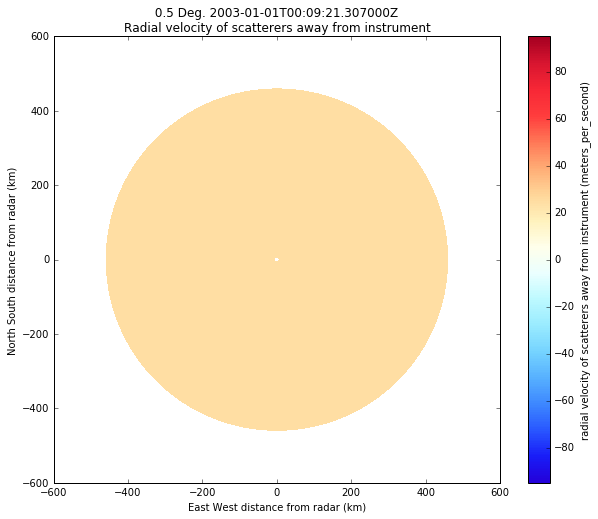

In [70]:
#Plot of reflectivity with Argonne and University of Chicago marked on the plot.
display = pyart.graph.RadarMapDisplay(test_radar)
f = plt.figure(figsize = [10, 8])
display.plot('velocity')
plt.show()

In [37]:
vad['u_mean']

array([ 0.89016619, -0.29893289, -1.11261068, -1.49001421, -1.28060098,
       -0.77243537, -0.06844686,  0.65546802,  1.56376553,  2.3407313 ,
        3.15940101,  3.81753455,  4.36255287,  5.0784226 ,  5.47382029,
        5.95468326,  6.67462533,  6.95079671,  7.47475892,  7.64292435,
        8.08027315,  7.97054359,  7.49222062,  7.53774004,  7.70045311,
        7.73208228,  7.78151572,  8.01844593,  8.13136691,  7.80875246,
        8.50595345,  8.24643853,  7.51984601,  7.23722566,  7.81056785,
        7.51082274,  7.81466749,  7.24810567,  9.58263146,  9.12781423,
        9.15428679,  8.2969847 ,  7.8972833 ,  7.40999254,  7.39805188,
        8.81757648,  8.03907208,  7.38704553,  8.03617347,  7.92878156,
        4.96146499,  7.93685236,  7.36415607,  7.27277868,  7.34570031,
        7.49204339,  6.27464716,  6.62374637,  5.52774403,  7.45952154,
        6.86400759,  6.19485851,  5.14717194,  6.24172461,  7.27983946,
        3.97628789,  5.21217964,  6.13841505,  4.70140517,  4.12

In [38]:
vad['v_mean']

array([ -0.34519285,   0.30903051,   1.29106813,   2.48050362,
         3.39915173,   4.37684255,   5.33184302,   5.96884358,
         6.56407848,   7.16769357,   7.79582166,   8.01189264,
         8.17784722,   8.38662088,   8.55250158,   8.68652233,
         9.03048448,   9.08369285,   9.38086315,   9.25285163,
         9.63751184,   9.46955288,   8.5548789 ,   8.75276267,
         8.89277563,   9.15075658,   9.29837515,   9.53262681,
         9.6007065 ,   9.42196748,  10.04380818,   9.85178509,
         8.54891366,   8.40489394,   8.83374725,   8.62314598,
         9.13843922,   8.60037989,  11.09988896,  10.58111844,
        11.26017605,  10.82365435,  11.10426749,   9.84999361,
         9.56711278,   9.35199979,   9.65505933,   9.6085824 ,
         9.84382566,   9.8470269 ,  10.84182726,   9.65024964,
         9.97247283,   9.61907204,   9.46879603,   9.86669374,
         9.92784065,  10.3266048 ,  10.06222867,   8.35443396,
         8.3581917 ,   8.95817461,   8.82143685,   8.81

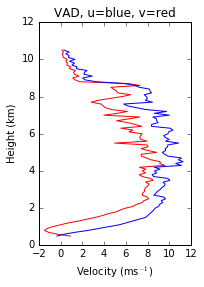

In [39]:
fig = plt.figure()
plt.subplot(1, 2, 1)
plt.plot(vad['u_mean'], vad['z_interval'] / 1000.0, 'r-')
plt.plot(vad['v_mean'], vad['z_interval'] / 1000.0, 'b-')
plt.xlabel(r'Velocity (ms$^{-1}$)')
plt.ylabel(r'Height (km)')
plt.title('VAD, u=blue, v=red')
plt.show()

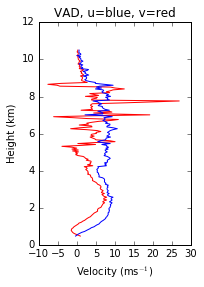

In [35]:
fig = plt.figure()
plt.subplot(1, 2, 1)
plt.plot(vad3['u_mean'], vad3['z_interval'] / 1000.0, 'r-')
plt.plot(vad3['v_mean'], vad3['z_interval'] / 1000.0, 'b-')
plt.xlabel(r'Velocity (ms$^{-1}$)')
plt.ylabel(r'Height (km)')
plt.title('VAD, u=blue, v=red')
plt.show()

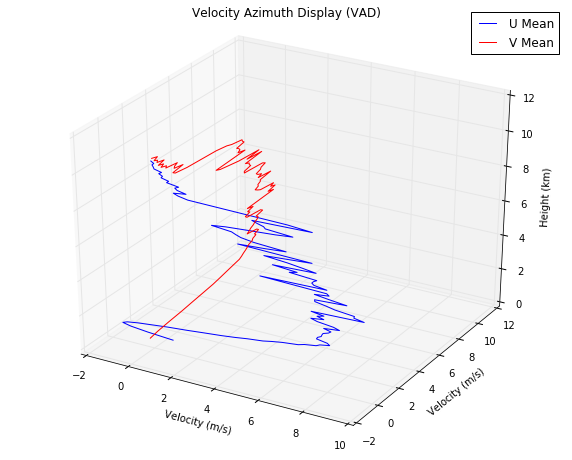

In [44]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
x1 = vad['u_mean']
x2 = vad['v_mean']
y = vad['z_interval']/1000
#plt.xlim(-12, 12)
#plt.ylim(-12, 12)
ax.title.set_position([.5, 1.05])
ax.set_title('Velocity Azimuth Display (VAD)')
ax.set_xlabel('Velocity (m/s)')
ax.set_ylabel('Velocity (m/s)')
ax.set_zlabel('Height (km)')
ax.plot(x1, np.zeros_like(x1), y, label='U Mean')
ax.plot(np.zeros_like(x2), x2, y, '-r', label='V Mean')
# default ax.azim = 300, default ax.elev = 30
ax.legend()
plt.show()

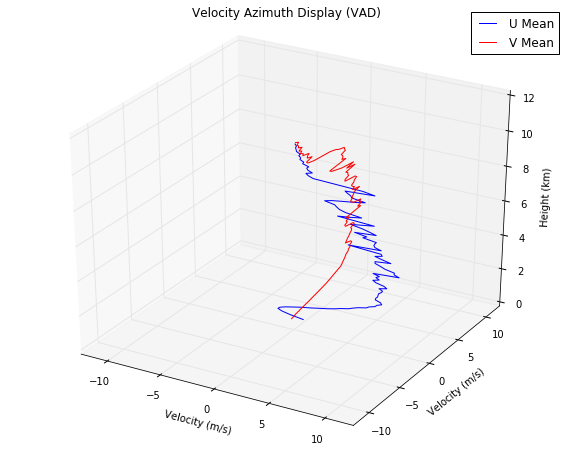

In [45]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
x1 = vad['u_mean']
x2 = vad['v_mean']
y = vad['z_interval']/1000
plt.xlim(-12, 12)
plt.ylim(-12, 12)
ax.title.set_position([.5, 1.05])
ax.set_title('Velocity Azimuth Display (VAD)')
ax.set_xlabel('Velocity (m/s)')
ax.set_ylabel('Velocity (m/s)')
ax.set_zlabel('Height (km)')
ax.plot(x1, np.zeros_like(x1), y, label='U Mean')
ax.plot(np.zeros_like(x2), x2, y, '-r', label='V Mean')
# default ax.azim = 300, default ax.elev = 30
ax.legend()
plt.show()

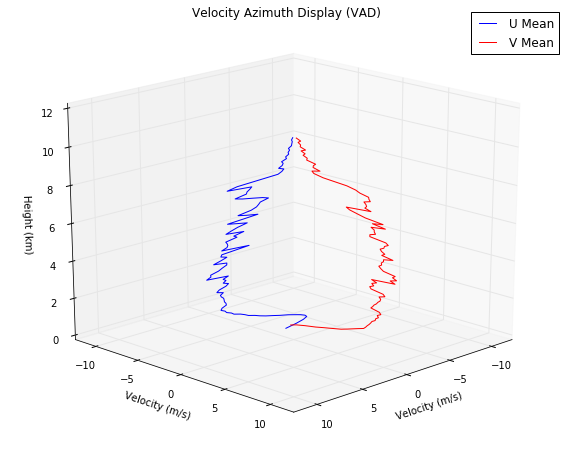

In [41]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
x1 = vad['u_mean']
x2 = vad['v_mean']
y = vad['z_interval']/1000
plt.xlim(-12, 12)
plt.ylim(-12, 12)
ax.title.set_position([.5, 1.05])
ax.set_title('Velocity Azimuth Display (VAD)')
ax.set_xlabel('Velocity (m/s)')
ax.set_ylabel('Velocity (m/s)')
ax.set_zlabel('Height (km)')
ax.plot(x1, np.zeros_like(x1), y, label='U Mean')
ax.plot(np.zeros_like(x2), x2, y, '-r', label='V Mean')
ax.azim = 45
ax.elev = 20
ax.legend()
plt.show()

In [ ]:
    # Setting parameters for the pcolormesh plots.
    def polar_plot(self, field, sweep=0, ax=None, **kwargs):
        """
        Creates a polar plot.

        Parameters
        ----------
        radar : Radar
            Radar object Used.
        field : str
            Field to plot.

        Other Parameters
        ----------------
        vmin : float
            Luminance minimum value, None for default value.
            Parameter is ignored is norm is not None.
        vmax : float
            Luminance maximum value, None for default value.
            Parameter is ignored is norm is not None.
        title : str
            Title to label plot with, None to use default title generated from
            the field and tilt parameters. Parameter is ignored if title_flag
            is False.
        title_flag : bool
            True to add a title to the plot, False does not add a title.
        """

        ax.cla()
        ax.set_theta_zero_location("N")
        ax.set_theta_direction(-1)
        i_s = radar.sweep_start_ray_index['data'][sweep]
        i_e = radar.sweep_end_ray_index['data'][sweep]
        order = np.argsort(radar.azimuth['data'][i_s:i_e])
        # rectangular plot of polar data
        theta, rad = np.meshgrid(radar.azimuth['data'][i_s:i_e][order],
                                 radar.range['data'])
        X = theta * np.pi / 180.0
        Y = rad / 1000.0
        if 'mask' in kwargs.keys():
            pcolor = ax.pcolormesh(
                X, Y, np.ma.masked_where(
                    kwargs['mask'][
                        i_s:i_e, :][
                        order, :].transpose(), radar.fields[var]['data'][
                        i_s:i_e, :][
                            order, :].transpose()), vmin=kwargs.get(
                                'vmin', -6), vmax=kwargs.get(
                                    'vmax', 64))
        else:
            pcolor = ax.pcolormesh(
                X, Y,
                radar.fields[field]['data'][i_s:i_e, :][order, :].transpose(),
                vmin=kwargs.get('vmin', -6),
                vmax=kwargs.get('vmax', 64))

        ax.set_title(radar.metadata['instrument_name']
                     + ' ' + str(datetimes) + ' ' + field, y=1.08)

        if 'ylim' in kwargs:
            ylim(kwargs['ylim'])
        plt.grid(True)
        return pcolor

In [ ]:
# Pcolormesh of reflectivity and the number of gates a specific dBZ occurs.
good = np.where(np.logical_not(is_bad[:, 0:-20].flatten()))[0]
H, xedges, yedges = np.histogram2d(
    z[:, 0:-20].flatten()[good] / 1000.0,
    myradar.fields['reflectivity']['data'][:, 0:-20].flatten()[good],
    bins=(62, 60), range=([0, 12], [-10, 64]))

fig = plt.figure(figsize=[8, 5])
plt.pcolormesh(yedges, xedges, H)
plt.xlabel('Refl fac (dBZ)')
plt.ylabel('height (km)')
color_bar = plt.colorbar()
color_bar.set_label('ngates')
plt.xlim(-10, 64)
plt.title('CFAD of Reflectivity Factor')
plt.savefig('/home/zsherman/VAD/images/cfad_z_'
            + str(datetimes) + '.png', dpi=200,)
plt.show()

In [ ]:
# Below is some code from Susan Rennie (based off Michelson et al 2000)
# from the Centre for Australian Weather and Climate Research (CAWCR)
# for calculating VADs. I used her one tilt version and wrote my own adaptation
# into Py-ART PyRadar object.. Note I convert to U and V before averaging..
# my concern is that if you have θ rapidly varying between 360∘ and 0∘
# this will average to a nonsense number.

In [ ]:
# Location of each gate in a Cartesian coordinate system 
# assuming a standard atmosphere with a 4/3 Earth’s radius model.
x = radar.gate_x['data']
y = radar.gate_y['data']
z = radar.gate_z['data']

In [ ]:
print(np.max(myradar.gate_z['data']))
print(myradar.gate_z['units'])

In [ ]:
gatefilter = pyart.correct.GateFilter(myradar)
mask = gatefilter.exclude_below('cross_correlation_coefficient', 0.8)

In [ ]:
print(myradar.fixed_angle)

In [ ]:
is_bad = np.logical_or(
    myradar.fields['norm_coh_power']['data'] < 0.5,
    myradar.fields['cross_correlation_coefficient']['data'] < 0.8)

In [ ]:
# Pcolormesh of reflectivity
fig = plt.figure()
ax = fig.add_axes([0.0, 0.0, .9, .9], polar=True)
pcolor = polar_plot(myradar, 1, ax, 'reflectivity', mask=is_bad)
color_bar = plt.colorbar(mappable=pcolor, pad=0.10)
color_bar.set_label('Eq Refl factor (dBZ)')
plt.savefig('/home/zsherman/VAD/images/csapr_dbz_ppi.'
            + str(datetimes) + '.png', dpi=400,  bbox_inches='tight')

In [ ]:
# Pcolormesh of corrected mean doppler velocity.
fig = plt.figure()
ax = fig.add_axes([0.0, 0.0, .9, .9], polar=True)
pcolor = polar_plot(myradar, 1, ax, 'CVD',
                    mask=is_bad, vmin=-20, vmax=20)
color_bar = plt.colorbar(mappable=pcolor, pad=0.10)
color_bar.set_label(r'Mean Doppler Velocity (ms$^{-1}$, +out)')
plt.savefig('/home/zsherman/VAD/images/csapr_vel_ppi.'
            + str(datetimes) + '.png', dpi=400,  bbox_inches='tight')

In [ ]:
z_want = np.linspace(500, 10500, 101)
u_mean, v_mean = VAD(myradar, z_want)

In [ ]:
# pyart.core.HorizontalWindProfile(height, speed, direction,
                                 # latitude=None, longitude=None)

In [ ]:
fig = plt.figure()
plt.subplot(1, 2, 1)
plt.plot(u_mean, z_want / 1000.0, 'r-')
plt.plot(v_mean, z_want / 1000.0, 'b-')
plt.xlabel(r'Velocity (ms$^{-1}$)')
plt.ylabel(r'Height (km)')
plt.title('VAD, u=blue, v=red')
plt.show()

In [ ]:
ylims = [0, 10]
fig = plt.figure()
ax1 = fig.add_axes([0.1, 0.1, .3, .8])
plt.plot(u_mean, z_want / 1000.0, 'r-')
plt.plot(v_mean, z_want / 1000.0, 'b-')
plt.ylim(ylims)
# ax1.xaxis.set_major_locator(MaxNLocator(prune='upper'))
plt.xlabel(r'Velocity (ms$^{-1}$)')
plt.ylabel(r'Height (km)')
plt.title('VAD, u=blue, v=red')
ax2 = fig.add_axes([0.4, 0.1, .5, .8])
plt.pcolormesh(yedges, xedges, H)
plt.ylim(ylims)
plt.xlim([-10, 40])
ax2.xaxis.set_major_locator(plt.MaxNLocator(prune='lower'))
ax2.get_yaxis().set_visible(False)
plt.xlabel('Refl fac (dBZ)')
color_bar = plt.colorbar()
color_bar.set_label('ngates')
plt.title('CFAD of Reflectivity Factor')
# fig.text(.3,.96,time_str)
plt.savefig('/home/zsherman/VAD/images/combo_'
            + str(datetimes) + '.png', dpi=200,  bbox_inches='tight')
plt.show()

In [ ]:
ylims = [0, 10]
fig = plt.figure(figsize=[10, 10])
ax1 = fig.add_axes([0.1, 0.5, .3, .3])
plt.plot(u_mean, z_want / 1000.0, 'r-')
plt.plot(v_mean, z_want / 1000.0, 'b-')
plt.ylim(ylims)
# ax1.xaxis.set_major_locator(MaxNLocator(prune='upper'))
plt.xlabel(r'Velocity (ms$^{-1}$)')
plt.ylabel(r'Height (km)')
plt.title('VAD, u=blue, v=red')
ax2 = fig.add_axes([0.4, 0.5, .5, .3])
plt.pcolormesh(yedges, xedges, H)
plt.ylim(ylims)
plt.xlim([-10, 40])
ax2.xaxis.set_major_locator(plt.MaxNLocator(prune='lower'))
ax2.get_yaxis().set_visible(False)
plt.xlabel('Refl fac (dBZ)')
color_bar = plt.colorbar()
color_bar.set_label('ngates')
plt.title('CFAD of Reflectivity Factor')
# fig.text(.3,.96,time_str)

ax3 = fig.add_axes([0.05, 0.05, .4, .4], polar=True)
pc = polar_plot(myradar, 1, ax3, 'reflectivity', mask=is_bad)
color_bar = plt.colorbar(mappable=pc, pad=0.10)
color_bar.set_label('Eq Refl factor (dBZ)')
plt.savefig('/home/zsherman/VAD/images/csapr_dbz_ppi.'
            + str(datetimes) + '.png', dpi=400,  bbox_inches='tight')

ax4 = fig.add_axes([0.5, 0.05, .4, .4], polar=True)
pc = polar_plot(myradar, 1, ax4, 'CVD', mask=is_bad, vmin=-20, vmax=20)
color_bar = plt.colorbar(mappable=pc, pad=0.10)
color_bar.set_label(r'Mean Doppler Velocity (ms$^{-1}$, +out)')
plt.savefig('/home/zsherman/VAD/images/super_combo_' + str(datetimes)
            + '.png', dpi=200,  bbox_inches='tight')